In [36]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import pickle
from torch import Tensor
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy.fft import rfft, rfftfreq, fft, fftfreq
import scipy
import time
import copy
from google.colab import drive

drive.mount('/content/drive')

# Load in Data
with open('/content/drive/MyDrive/CSE 481 Capstone/processed_data.npy', 'rb') as f:
    data = np.load(f)
print(data.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(17920, 4, 32, 32)


In [37]:
# Load in Labels
labels = pd.read_excel("/content/drive/MyDrive/CSE 481 Capstone/metadata_xls/participant_ratings.xls")
print(labels.head())
sub_labels = []
for i in range(len(labels)):
  sub_labels.append([labels.loc[i, 'Valence'] , labels.loc[i, 'Arousal']])
sub_labels = np.array(sub_labels)
print(sub_labels.shape)
print(sub_labels)

# convert to windowed labels
data_labels = np.repeat(sub_labels, 14, axis=0)
print(data_labels.shape)
print(data_labels)

#convert to tensor
#ata = torch.tensor(data)
data = torch.from_numpy(data).float()
data_labels = torch.from_numpy(data_labels).float()
print(data.dtype)
print(data.shape)
dataset = TensorDataset(Tensor(data) , Tensor(data_labels))
print(data[29][1])

   Participant_id  Trial  Experiment_id  ...  Dominance  Liking  Familiarity
0               1      1              5  ...       7.19    6.05          4.0
1               1      2             18  ...       6.94    8.01          4.0
2               1      3              4  ...       6.12    8.06          4.0
3               1      4             24  ...       8.01    8.22          4.0
4               1      5             20  ...       7.19    8.13          1.0

[5 rows x 9 columns]
(1280, 2)
[[6.96 3.92]
 [7.23 7.15]
 [4.94 6.01]
 ...
 [8.05 7.09]
 [4.01 7.17]
 [4.08 5.95]]
(17920, 2)
[[6.96 3.92]
 [6.96 3.92]
 [6.96 3.92]
 ...
 [4.08 5.95]
 [4.08 5.95]
 [4.08 5.95]]
torch.float32
torch.Size([17920, 4, 32, 32])
tensor([[ 1.0000,  0.6335,  0.4222,  ..., -0.0332,  0.3070,  0.1884],
        [ 0.6335,  1.0000,  0.8858,  ..., -0.0963,  0.4528,  0.2397],
        [ 0.4222,  0.8858,  1.0000,  ...,  0.0902,  0.4818,  0.2817],
        ...,
        [-0.0332, -0.0963,  0.0902,  ...,  1.0000,  0.4132,

In [38]:
pre_train_size = int(0.9 * len(dataset))
test_size = len(dataset) - pre_train_size
pre_train_set, test_set = torch.utils.data.random_split(dataset, [pre_train_size, test_size])
train_size = int(0.8 * len(pre_train_set))
val_size = len(pre_train_set) - train_size
print(len(pre_train_set))
print(train_size)
print(val_size)
train_set, val_set = torch.utils.data.random_split(pre_train_set, [train_size, val_size])

batch_size = 128
print(len(train_set), len(val_set), len(test_set))
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
dataloaders = {
    'train': trainloader,
    'val': valloader,
}

16128
12902
3226
12902 3226 1792


In [39]:
# with auto encoder
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# skipped autoencoder
model = nn.Sequential(
    nn.Conv2d(4, 32, [3, 1]),
    nn.ReLU(),
    nn.Dropout(),
    nn.Conv2d(32, 64, [3, 1]),
    nn.ReLU(), # Maybe not sure
    nn.Dropout(),
    nn.MaxPool2d([3, 3]),
    nn.Flatten(),
    nn.Linear(5760, 2048),
    nn.ReLU(),
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 2)
)
model.to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

cuda:0
Sequential(
  (0): Conv2d(4, 32, kernel_size=[3, 1], stride=(1, 1))
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Conv2d(32, 64, kernel_size=[3, 1], stride=(1, 1))
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): MaxPool2d(kernel_size=[3, 3], stride=[3, 3], padding=0, dilation=1, ceil_mode=False)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=5760, out_features=2048, bias=True)
  (9): ReLU()
  (10): Linear(in_features=2048, out_features=1024, bias=True)
  (11): ReLU()
  (12): Linear(in_features=1024, out_features=512, bias=True)
  (13): ReLU()
  (14): Linear(in_features=512, out_features=256, bias=True)
  (15): ReLU()
  (16): Linear(in_features=256, out_features=128, bias=True)
  (17): ReLU()
  (18): Linear(in_features=128, out_features=2, bias=True)
)


In [40]:
def accuracy(input):
  output = np.zeros((len(input)))
  for i in range(len(input)):
    instance = input[i]
    valence = instance[0]
    arousal = instance[1]
    if (valence < 5 and arousal < 5):
      output[i] = 0
    elif (valence < 5 and arousal >= 5):
      output[i] = 1
    elif (valence >= 5 and arousal < 5):
      output[i] = 2
    else:
      output[i] = 3
  return output

In [41]:
since = time.time()
best_model_wts = copy.deepcopy(model.state_dict())
best_loss = 10000.0
all_train_loss = []
all_val_loss = []
num_epochs = 251
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            #print(inputs)
            #print(labels)
            

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                #print(outputs)
                #_, preds = torch.max(outputs, 1)
                #print(preds)
                #print(outputs.dtype)
                #print(labels.dtype)
                loss = loss_func(outputs, labels)
                #print(loss.item())

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()

                #print(running_loss)
                #print(outputs)
                #print(accuracy(outputs))
                #print(accuracy(labels))
                if (epoch % 50 == 0):
                  running_corrects += np.sum(accuracy(outputs) == accuracy(labels)) / inputs.size(0)

        epoch_loss = running_loss / len(dataloaders[phase])
        #epoch_acc = running_corrects / len(dataloaders[phase])

        print('{} Loss: {:.4f}'.format(
            phase, epoch_loss))
        if (epoch % 50 == 0):
          print('Acc: {:.4f}'.format(running_corrects / len(dataloaders[phase])))
        if phase == 'train':
          all_train_loss.append(epoch_loss)
        else:
          all_val_loss.append(epoch_loss)
        # deep copy the model
        # if phase == 'val' and epoch_acc > best_acc:
        #     best_acc = epoch_acc
        #     best_model_wts = copy.deepcopy(model.state_dict())
        if phase == 'val' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
    print()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best Val Loss: {:4f}'.format(best_loss))

# load best model weights
model.load_state_dict(best_model_wts)

Epoch 0/250
----------
train Loss: 5.8313
Acc: 0.2983
val Loss: 19.5255
Acc: 0.2093

Epoch 1/250
----------
train Loss: 4.3484
val Loss: 18.4914

Epoch 2/250
----------
train Loss: 4.4498
val Loss: 20.4185

Epoch 3/250
----------
train Loss: 4.4264
val Loss: 19.1867

Epoch 4/250
----------
train Loss: 4.3910
val Loss: 18.4788

Epoch 5/250
----------
train Loss: 4.3113
val Loss: 18.2760

Epoch 6/250
----------
train Loss: 4.3838
val Loss: 18.7332

Epoch 7/250
----------
train Loss: 4.3154
val Loss: 19.3658

Epoch 8/250
----------
train Loss: 4.3023
val Loss: 17.7667

Epoch 9/250
----------
train Loss: 4.2909
val Loss: 17.4455

Epoch 10/250
----------
train Loss: 4.2921
val Loss: 17.8596

Epoch 11/250
----------
train Loss: 4.2727
val Loss: 16.6515

Epoch 12/250
----------
train Loss: 4.3109
val Loss: 17.4777

Epoch 13/250
----------
train Loss: 4.2103
val Loss: 17.3218

Epoch 14/250
----------
train Loss: 4.1829
val Loss: 14.9634

Epoch 15/250
----------
train Loss: 4.1251
val Loss: 16.

<All keys matched successfully>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  This i

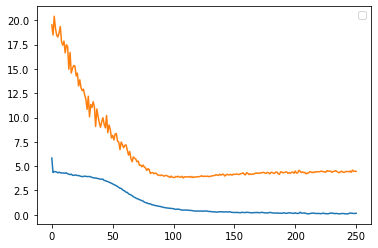

In [42]:
plt.plot(all_train_loss)
plt.plot(all_val_loss)
plt.legend('train', 'val')

In [43]:
running_loss = 0.0
running_corrects = 0
model.eval()

# Iterate over data.
for inputs, labels in testloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = loss_func(outputs, labels)

    # statistics
    running_loss += loss.item()
    running_corrects += np.sum(accuracy(outputs) == accuracy(labels)) / inputs.size(0)
epoch_loss = running_loss / len(testloader)
print('Test Loss: {:.4f}'.format(epoch_loss))
print('Test Acc: {:.4f}'.format(running_corrects / len(testloader)))
print()

Test Loss: 4.0487
Test Acc: 0.4436



In [44]:
model.eval()
datatestiter = iter(testloader)
input_test, labels_test = datatestiter.next()
input_test = input_test.to(device)
labels_test = labels_test.to(device)
output_test = model(input_test)
print(labels_test.shape)
print('outputs',output_test[0:8])
print('labels', labels_test[0:8])
print(np.sum(accuracy(output_test) == accuracy(labels_test)) / len(labels_test))

torch.Size([128, 2])
outputs tensor([[6.3695, 4.0121],
        [5.7445, 3.5266],
        [6.0666, 5.7542],
        [3.5111, 5.5414],
        [5.8918, 5.1671],
        [5.4484, 5.9509],
        [3.9376, 5.5091],
        [5.9140, 4.3339]], device='cuda:0', grad_fn=<SliceBackward>)
labels tensor([[4.8500, 4.6400],
        [4.0000, 3.0100],
        [3.0800, 7.0500],
        [6.0300, 4.9900],
        [2.8200, 6.3100],
        [3.1700, 8.0800],
        [8.0300, 4.3600],
        [1.9100, 1.0000]], device='cuda:0')
0.40625


In [45]:
torch.save(model.state_dict(), '/content/drive/MyDrive/CSE 481 Capstone/model.pth')